In [1]:
%reset 

Nothing done.


In [2]:
import mne
import yasa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
emg_highpass_cut = 20;
emg_lowpass_cut = 20;

ohad = {}
eeg_location_name = 'F';
ohad['electrodes'] =  {'EEG 1' : "EOG",
                              'EEG 2' : eeg_location_name,
                              'EEG 3' : "Nostr",
                              'EEG 4' : "Chin"}
ohad['chan_type'] =   {"EOG": 'eog',
                              eeg_location_name : 'eeg',
                              "Nostr":'emg',
                              "Chin":'emg'}
ohad['eeg_elect_pos'] = 1;
ohad['age'] = 32;
ohad['isMale'] = True;

ella = {}
eeg_location_name = 'pF';
ella['electrodes'] =  {'EEG 1' : "EOG",
                              'EEG 2' : eeg_location_name,
                              'EEG 3' : "Nostr",
                              'EEG 4' : "Chin"}
ella['chan_type'] =   {"EOG": 'eog',
                              eeg_location_name : 'eeg',
                              "Nostr":'emg',
                              "Chin":'emg'}
ella['eeg_elect_pos'] = 1;
ella['age'] = 43;
ella['isMale'] = False;

dir = 'C:\\Users\\User\\OneDrive\\Desktop\\lucidRecords\\recordings_openBCI\\Ella';
filename = "OpenBCI-BDF-2023-07-01_04-24-24";
curr_sub = ella

In [5]:
raw_bdf = mne.io.read_raw_bdf(f"{dir}\\{filename}.bdf",preload=True)
raw_bdf
mne.rename_channels(raw_bdf.info,curr_sub['electrodes'])
raw_bdf.set_channel_types( curr_sub['chan_type'])

print('The channels are:', raw_bdf.ch_names)
print('The sampling frequency is:', raw_bdf.info['sfreq'])

emg_only_fast = raw_bdf.copy().pick_types(meg=False, emg=True,verbose=False)
emg_only_slow = raw_bdf.copy().pick_types(meg=False, emg=True,verbose=False)
eeg_eog_only = raw_bdf.copy().pick_types(meg=False, eeg=True,eog=True,verbose=False)

emg_only_fast = emg_only_fast.notch_filter([50],picks='emg',verbose=False)
emg_only_slow = emg_only_slow.notch_filter([50],picks='emg',verbose=False)
eeg_eog_only = eeg_eog_only.notch_filter([50],picks=['eeg','eog'],verbose=False)

eeg_eog_only = eeg_eog_only.filter(0.3, 35,picks=['eeg','eog'],verbose=False)

emg_only_fast = emg_only_fast.filter(None,emg_highpass_cut,picks='emg',verbose=False)
emg_only_slow = emg_only_slow.filter(emg_lowpass_cut, None,picks='emg',verbose=False)

for emg_name in emg_only_fast.info.ch_names:
    mne.rename_channels(emg_only_fast.info, {emg_name : f"{emg_name}_hp{emg_highpass_cut}"})
    mne.rename_channels(emg_only_slow.info, {emg_name : f"{emg_name}_lp{emg_lowpass_cut}"})

Extracting EDF parameters from C:\Users\User\OneDrive\Desktop\lucidRecords\recordings_openBCI\Ella\OpenBCI-BDF-2023-07-01_04-24-24.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1376799  =      0.000 ...  6883.995 secs...
The channels are: ['EOG', 'pF', 'Nostr', 'Chin']
The sampling frequency is: 200.0


In [6]:
filtered = eeg_eog_only.copy().pick_types(meg=False, eeg=True,eog=True)
filtered.add_channels(add_list=[emg_only_fast,emg_only_slow],force_update_info=True) # Notice! The merge is forced, therefore the hp/lp info is distorted in the info structure

<RawEDF | OpenBCI-BDF-2023-07-01_04-24-24.bdf, 6 x 1376800 (6884.0 s), ~63.0 MB, data loaded>

In [7]:
filtered.info.ch_names

['EOG', 'pF', 'Nostr_hp20', 'Chin_hp20', 'Nostr_lp20', 'Chin_lp20']

In [8]:
mne.export.export_raw(f"{dir}\\{filename}_filtered.edf", filtered,fmt='edf',overwrite=True)

Yasa automated scoring

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
01-Jul-23 14:04:15 | WARNING | Hypnogram is SHORTER than data by 14.00 seconds. Padding hypnogram with last value to match data.size.


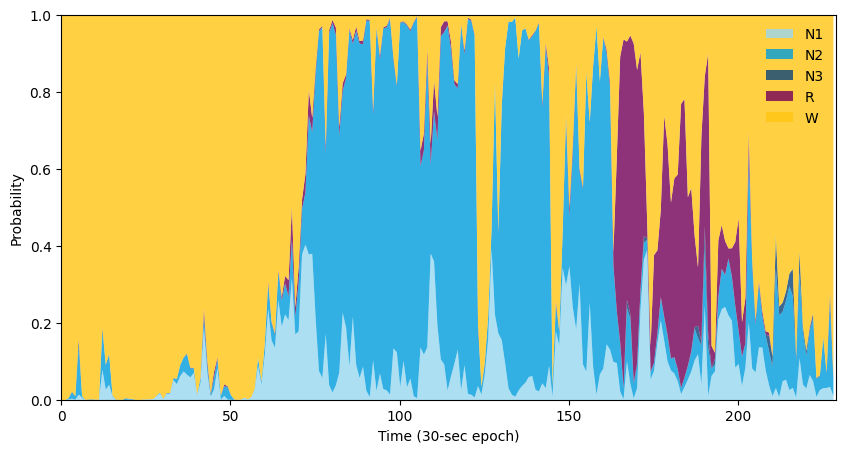

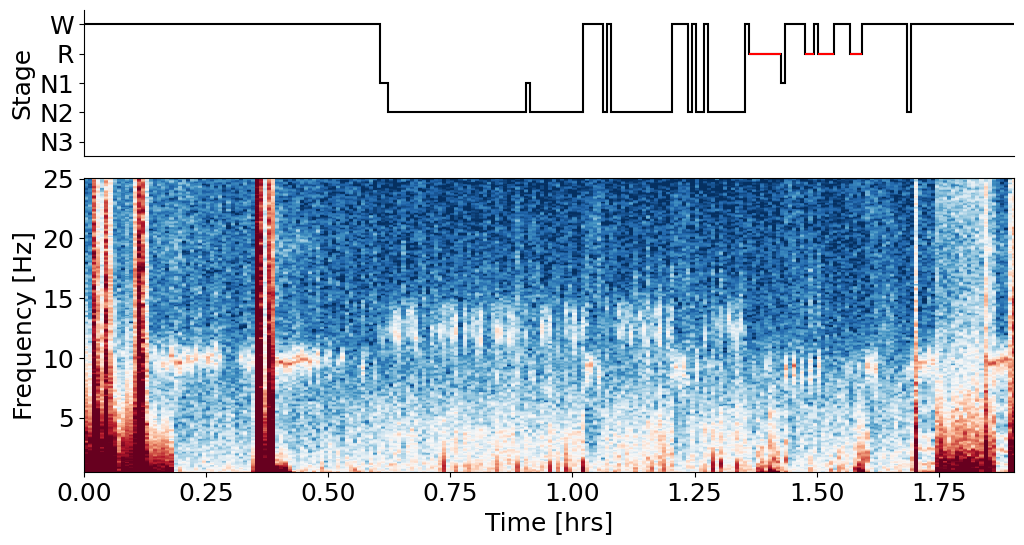

In [9]:
# predict using eeg, eog, chin_emg
sls = yasa.SleepStaging(filtered, eeg_name=eeg_location_name, eog_name='EOG', emg_name= f"Chin_hp{emg_highpass_cut}", metadata=dict(age=curr_sub['age'], male=curr_sub['isMale']))
y_pred = sls.predict()
sls.plot_predict_proba();

new_format_score = np.zeros((len(y_pred),3), dtype=object)
for ind, score in enumerate(y_pred):
        new_format_score[ind,:] = [30*ind,30,y_pred[ind]] ## onset (sec), duration, desc

np.savetxt(f"{dir}\\{filename}_autoScore.txt", new_format_score, delimiter='\t',fmt='%s')

data = filtered.get_data()
hypno_pred = yasa.hypno_str_to_int(y_pred)  # Convert "W" to 0, "N1" to 1, etc
hypno_up = yasa.hypno_upsample_to_data(hypno_pred, sf_hypno=1/30, data=raw_bdf)
yasa.plot_spectrogram(data[curr_sub['eeg_elect_pos'],:], raw_bdf.info['sfreq'],hypno_up);  
#yasa.plot_hypnogram(hypno_pred);  # Plot

01-Jul-23 14:06:54 | INFO | Using pre-trained classifier: c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\yasa\classifiers\clf_eeg+demo_lgb_0.5.0.joblib
c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
01-Jul-23 14:06:54 | WARNING | Hypnogram is SHORTER than data by 14.00 seconds. Padding hypnogram with last value to match data.size.


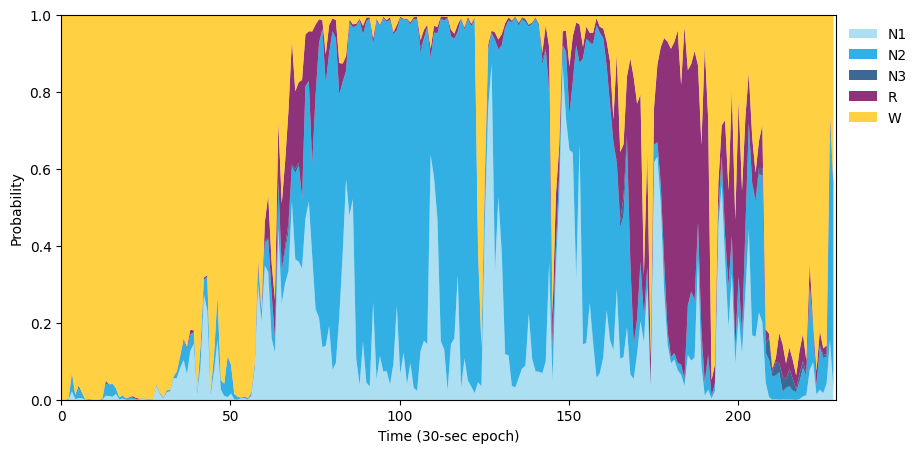

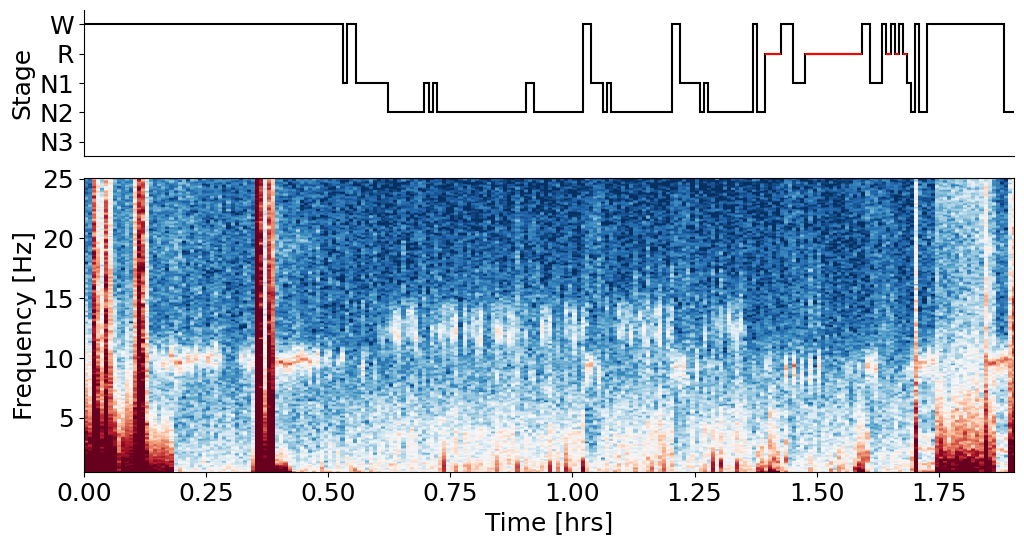

In [10]:
# predict using eeg only
sls = yasa.SleepStaging(filtered, eeg_name=eeg_location_name, metadata=dict(age=curr_sub['age'], male=curr_sub['isMale']))
y_pred = sls.predict()
sls.plot_predict_proba();

new_format_score = np.zeros((len(y_pred),3), dtype=object)
for ind, score in enumerate(y_pred):
        new_format_score[ind,:] = [30*ind,30,y_pred[ind]] ## onset (sec), duration, desc

np.savetxt(f"{dir}\\{filename}_EEGautoScore.txt", new_format_score, delimiter='\t',fmt='%s')

data = filtered.get_data()
hypno_pred = yasa.hypno_str_to_int(y_pred)  # Convert "W" to 0, "N1" to 1, etc
hypno_up = yasa.hypno_upsample_to_data(hypno_pred, sf_hypno=1/30, data=raw_bdf)
yasa.plot_spectrogram(data[curr_sub['eeg_elect_pos'],:], raw_bdf.info['sfreq'],hypno_up);  #         
#yasa.plot_hypnogram(hypno_pred);  # Plot
